Final Project by Alicia Bergeron and Nick Arangio

Installation instructions, create pip venv, and install all required files using requirements.txt

Once done, ensure you are in the correct env in terminal and type the following:

python -m ipykernel intall --user --name:[env name]

In [76]:
import argparse
import functools
import logging
import os
import math

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
from collections import Counter

import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import constraints
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, JitTraceEnum_ELBO, TraceEnum_ELBO, NUTS, MCMC, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

stop = set(stopwords.words('english'))
pyro.set_rng_seed(0)
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

### Dataset Information
Sentiments: sadness, anger, love, surprise, fear, joy

In [77]:
dataset = 'Emotions dataset for NLP/train.txt'

NLTK Tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [78]:
ds = pd.read_csv(dataset, sep=';', header=None)
ds.columns = ["Text", "Sentiment"]
display(ds.head())
display(ds.Sentiment.unique())
display(ds.describe())
display(ds.iloc[3111])

def filter(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in str(text).split() if word not in stop])
df = ds
df.Text = df.Text.apply(lambda t: filter(t))



,Text,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

,Text,Sentiment
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


Text         in the army
Sentiment          anger
Name: 3111, dtype: object

In [79]:
dfA = df
dfA.Sentiment = dfA.Sentiment.map({
    'sadness':1,
    'anger':2,
    'love':3,
    'surprise':4,
    'fear':5,
    'joy':6
}
)

False

,Text,Sentiment,Length
0,didnt feel humiliated,1,3
1,go feeling hopeless damned hopeful around some...,1,9
2,grabbing minute post feel greedy wrong,2,6
3,ever feeling nostalgic fireplace know still pr...,3,7
4,feeling grouchy,2,2


<Axes: xlabel='Length'>

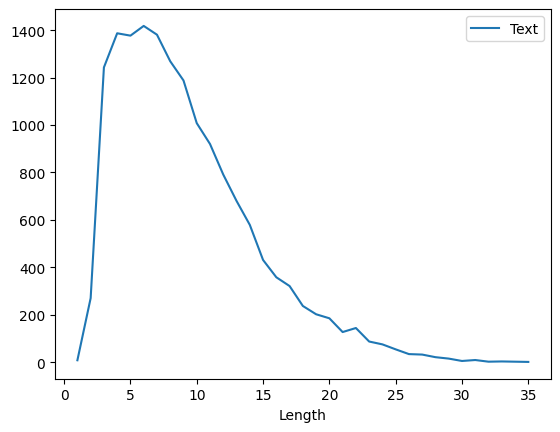

In [80]:
df['Length'] = dfA.Text.str.split("\\s+").apply(lambda a: len(a))
graphing = df.groupby('Length').nunique()
# display(graphing)
display(df['Length'].iloc[0] > 5)
display(df.head())
norm_index = df[(df['Length'] < 5) | (df['Length'] > 20)].index
df_norm = df.drop(norm_index)

graphing.plot(y='Text', use_index=True, kind='line')

In [81]:
df_norm.describe()

,Sentiment,Length
count,12370.000000,12370.000000
mean,3.614551,9.881083
std,2.117958,3.865598
min,1.000000,5.000000
25%,1.000000,7.000000
50%,4.000000,9.000000
75%,6.000000,12.000000
max,6.000000,20.000000


In [82]:
vocab = Counter()
df_norm.Text.str.lower().str.split().apply(vocab.update)
len(list(vocab.keys()))

12182

In [91]:
analysis = {}
for index, row in df_norm.iterrows():
    for w in str(row['Text']).split():
        if w in analysis:
            analysis[w] += row['Sentiment']
        else:
            analysis [w] = row['Sentiment']
# print(analysis)

In [84]:
for key in analysis:
    # print(analysis[key])
    # print(key)
    analysis[key] = [analysis[key] / vocab[key], vocab[key]]


In [85]:
new_analysis = {k: v for k, v in analysis.items() if v[1] <= 300}
outliers = {k: v for k, v in analysis.items() if v[1] > 300}
print(outliers)


{'go': [3.7305555555555556, 360], 'feeling': [3.51149291850476, 4307], 'feel': [3.6437590792267294, 8949], 'know': [3.398701298701299, 770], 'still': [3.428861788617886, 492], 'ive': [3.3782696177062372, 497], 'little': [3.5768595041322313, 605], 'time': [3.64087061668682, 827], 'like': [3.537519747235387, 2532], 'life': [3.527237354085603, 514], 'make': [3.923538230884558, 667], 'something': [3.8067415730337077, 445], 'think': [3.6216216216216215, 518], 'work': [3.8172757475083055, 301], 'thing': [3.3663194444444446, 576], 'dont': [3.4262295081967213, 427], 'need': [3.6481481481481484, 378], 'get': [3.5427728613569323, 678], 'day': [3.6269982238010656, 563], 'pretty': [3.9714285714285715, 315], 'much': [3.5734265734265733, 429], 'would': [3.4527272727272726, 550], 'want': [3.512690355329949, 591], 'bit': [3.2772511848341233, 422], 'way': [3.511879049676026, 463], 'one': [3.5672727272727274, 550], 'could': [3.5762711864406778, 413], 'people': [3.629370629370629, 572], 'back': [3.422619

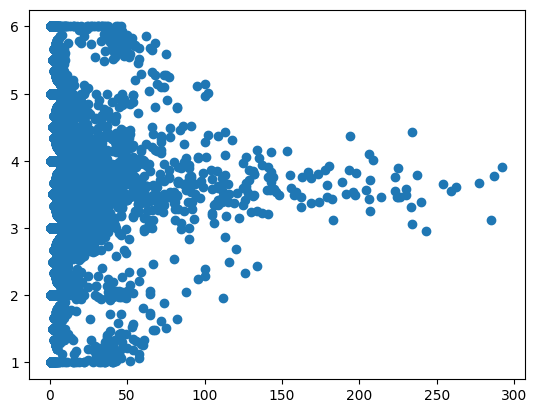

In [86]:
txt = new_analysis.keys
values = list(new_analysis.values())
fig, ax = plt.subplots()
ax.scatter([item[1] for item in values], [item[0] for item in values])


### Variable Definitions:
N = number of unique words in total vocabulary
T = numebr of topics in total document of twweets
alpha = parameter 

In [ ]:
df_sad = df_norm[df_norm["Sentiment"] == 1]
df_sad = df_sad.groupby(df_sad.index // 5)['Text'].apply(' '.join)
df_anger = df_norm[df_norm["Sentiment"] == 2]
df_anger = df_anger.groupby(df_anger.index // 5)['Text'].apply(' '.join)
df_love = df_norm[df_norm["Sentiment"] == 3]
df_love = df_love.groupby(df_love.index // 5)['Text'].apply(' '.join)
df_surprise = df_norm[df_norm["Sentiment"] == 4]
df_surprise = df_surprise.groupby(df_surprise.index // 5)['Text'].apply(' '.join)
df_fear = df_norm[df_norm["Sentiment"] == 5]
df_fear = df_fear.groupby(df_fear.index // 5)['Text'].apply(' '.join)
df_joy = df_norm[df_norm["Sentiment"] == 6]
df_joy = df_joy.groupby(df_joy.index // 5)['Text'].apply(' '.join)

df_concat = pd.concat([df_sad, df_anger, df_love, df_surprise, df_fear, df_joy], axis=0)
df_concat

In [48]:
# def mix_weights(beta):
#     beta1m_cumprod = (1 - beta).cumprod(-1)
#     print(beta1m_cumprod)
#     return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

# def model(data):
#     alpha = 0.1
#     T = 5
#     N = 30

#     # T-1 conditionally independent Beta distributions of B
#     with pyro.plate("beta_plate", T-1): 
#         beta = pyro.sample("beta", dist.Beta(1, alpha)) 

#     # T conditionally independent priors
#     with pyro.plate("mu_plate", T):
#         mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

#     # N conditionally independent Categorical distributions for cluster assignment
#     with pyro.plate("data", N):
#         z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
#         pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(2)), obs=data)

# model([1,1,1])

In [49]:
# def guide(data):
#     kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
#     tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
#     phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

#     with pyro.plate("beta_plate", T-1):
#         q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

#     with pyro.plate("mu_plate", T):
#         q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(2)))

#     with pyro.plate("data", N):
#         z = pyro.sample("z", dist.Categorical(phi))

In [50]:
# T = 10

# def train(num_iterations):
#     pyro.clear_param_store()
#     for j in tqdm(range(num_iterations)):
#         loss = svi.step(data)
#         losses.append(loss)

# def truncate(alpha, centers, weights):
#     threshold = alpha**-1 / 100.
#     true_centers = centers[weights > threshold]
#     true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
#     return true_centers, true_weights

# alpha = 0.1
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

# alpha = 1.5
# train(1000)

# # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
# Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

# plt.subplot(1, 2, 2)
# plt.scatter(data[:, 0], data[:, 1], color="blue")
# plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
# plt.tight_layout()
# plt.show()


In [51]:
# data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
#                      3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])
# counts = torch.unique(data, return_counts=True)[1].float()
# counts.sum()


In [52]:

# def model(counts):
#     theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
#     total_count = int(counts.sum())
#     pyro.sample('counts', dist.Multinomial(total_count, theta), obs=counts)

# data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
#                      3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])
# counts = torch.unique(data, return_counts=True)[1].float()

# nuts_kernel = NUTS(model)
# num_samples, warmup_steps = (1000, 200)
# mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
# mcmc.run(counts)
# hmc_samples = {k: v.detach().cpu().numpy()
#                for k, v in mcmc.get_samples().items()}

In [53]:
# means = hmc_samples['theta'].mean(axis=0)
# stds = hmc_samples['theta'].std(axis=0)
# print('Inferred dice probabilities from the data (68% confidence intervals):')
# for i in range(6):
#     print('%d: %.2f ± %.2f' % (i + 1, means[i], stds[i]))

In [54]:
# def model(data):
#     with pyro.plate("topics", T):
#         topic_weights = pyro.sample(
#             "topic_weights", dist.Gamma(1.0 / T, 1.0)
#         )
#         topic_words = pyro.sample(
#             "topic_words", dist.Dirichlet(torch.ones(N) / N)
#         )

#     with pyro.plate("documents", data.shape[0]) as ind:
#         doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
#         with pyro.plate("words", max_words):
#             word_topics = pyro.sample(
#                 "word_topics",
#                 dist.Categorical(doc_topics),
#                 infer={"enumerate": "parallel"},
#                 )
#             data = pyro.sample("doc_words", dist.Categorical(topic_words[word_topics]), obs=data)
#     return topic_weights, topic_words, data


# T = 20
# N = len(list(vocab.keys()))
# max_words = 12
# optim = Adam({"lr": 0.05})
# svi = SVI(model, guide, optim, loss=Trace_ELBO())
# losses = []


In [61]:
vectorizer = CountVectorizer(stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(df_norm['Text']).toarray())

8752
torch.Size([9378, 8752])
8951


In [36]:
def model(docs):
    with pyro.plate("beta", docs.size()[0]):
        
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones[1,T]))
    with pyro.plate("data", words):
        z = pyro.sample('obs', dist.Multinomial(words, theta), obs=words)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
T = 6
mcmc.run(docs)


hmc_samples = {k: v.detach().cpu().numpy()
               for k, v in mcmc.get_samples().items()}

  0%|          | 0/1500 [00:02<?, ?it/s]


ValueError: at site "obs", invalid log_prob shape
  Expected [8752], actual [9378, 8752]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

In [88]:
import tomotopy as tp

term_weight = tp.TermWeight.ONE

hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=8, gamma=1, alpha=0.1, initial_k = 4, seed=0)

for doc in list(df_concat):
    hdp.add_doc(doc.split())

hdp.burn_in = 100
hdp.train(0)
for i in tqdm(range(0, 10000, 100)):
    hdp.train(100)
    print(f'i: {i}, loss: {hdp.ll_per_word}, topics: {hdp.live_k}')
    n_topics = hdp.live_k

/var/folders/d5/d4vbmxhd4wxdb9smqpxs6x500000gn/T/ipykernel_33179/380873803.py:11: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/d5/d4vbmxhd4wxdb9smqpxs6x500000gn/T/ipykernel_33179/380873803.py:13: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(100)
  1%|          | 1/100 [00:00<01:32,  1.07it/s]

i: 0, loss: -7.525953962284248, topics: 30


  2%|▏         | 2/100 [00:02<01:42,  1.04s/it]

i: 100, loss: -7.492867265030906, topics: 37
i: 200, loss: -7.491677054618174, topics: 35


  4%|▍         | 4/100 [00:04<01:45,  1.10s/it]

i: 300, loss: -7.493253929001053, topics: 43
i: 400, loss: -7.492679076760149, topics: 39


  6%|▌         | 6/100 [00:06<01:39,  1.06s/it]

i: 500, loss: -7.490428087064546, topics: 37
i: 600, loss: -7.492871783478086, topics: 41


  8%|▊         | 8/100 [00:08<01:37,  1.06s/it]

i: 700, loss: -7.492929448993541, topics: 41
i: 800, loss: -7.493706294792736, topics: 39


 10%|█         | 10/100 [00:10<01:35,  1.06s/it]

i: 900, loss: -7.490780328491356, topics: 34
i: 1000, loss: -7.491692190411254, topics: 41


 12%|█▏        | 12/100 [00:12<01:35,  1.09s/it]

i: 1100, loss: -7.491930656500796, topics: 39
i: 1200, loss: -7.492027136998707, topics: 43


 14%|█▍        | 14/100 [00:15<01:34,  1.10s/it]

i: 1300, loss: -7.492818256517917, topics: 35
i: 1400, loss: -7.49244842625813, topics: 42


 16%|█▌        | 16/100 [00:17<01:31,  1.08s/it]

i: 1500, loss: -7.492122054027163, topics: 38
i: 1600, loss: -7.491884433711445, topics: 41


 18%|█▊        | 18/100 [00:19<01:27,  1.07s/it]

i: 1700, loss: -7.491717136363969, topics: 39
i: 1800, loss: -7.492475419607722, topics: 39


 20%|██        | 20/100 [00:21<01:25,  1.07s/it]

i: 1900, loss: -7.493085248622854, topics: 42
i: 2000, loss: -7.492567163363593, topics: 35


 22%|██▏       | 22/100 [00:23<01:22,  1.06s/it]

i: 2100, loss: -7.493015380103591, topics: 41
i: 2200, loss: -7.490981297828952, topics: 39


 24%|██▍       | 24/100 [00:25<01:21,  1.08s/it]

i: 2300, loss: -7.493264894558022, topics: 47
i: 2400, loss: -7.493789945342277, topics: 41


 26%|██▌       | 26/100 [00:27<01:19,  1.08s/it]

i: 2500, loss: -7.492832882446216, topics: 41
i: 2600, loss: -7.491812449081547, topics: 42


 28%|██▊       | 28/100 [00:29<01:16,  1.07s/it]

i: 2700, loss: -7.491929159364586, topics: 39
i: 2800, loss: -7.491601300415538, topics: 37


 30%|███       | 30/100 [00:32<01:14,  1.07s/it]

i: 2900, loss: -7.491499179111531, topics: 44
i: 3000, loss: -7.492456993500061, topics: 43


 32%|███▏      | 32/100 [00:34<01:12,  1.06s/it]

i: 3100, loss: -7.49268775750569, topics: 42
i: 3200, loss: -7.490764337580525, topics: 39


 34%|███▍      | 34/100 [00:36<01:09,  1.06s/it]

i: 3300, loss: -7.493704910501581, topics: 40
i: 3400, loss: -7.491885248098635, topics: 35


 36%|███▌      | 36/100 [00:38<01:11,  1.12s/it]

i: 3500, loss: -7.492304096487937, topics: 37
i: 3600, loss: -7.4920102529439605, topics: 37


 38%|███▊      | 38/100 [00:41<01:11,  1.16s/it]

i: 3700, loss: -7.493030642587581, topics: 39
i: 3800, loss: -7.492303948097094, topics: 40


 40%|████      | 40/100 [00:43<01:14,  1.24s/it]

i: 3900, loss: -7.49170965996207, topics: 41
i: 4000, loss: -7.492416167206316, topics: 41


 42%|████▏     | 42/100 [00:46<01:11,  1.23s/it]

i: 4100, loss: -7.493692554407978, topics: 47
i: 4200, loss: -7.49242773043453, topics: 43


 44%|████▍     | 44/100 [00:49<01:14,  1.33s/it]

i: 4300, loss: -7.491553160053754, topics: 38
i: 4400, loss: -7.492379255812791, topics: 38


 46%|████▌     | 46/100 [00:51<01:05,  1.21s/it]

i: 4500, loss: -7.492014330520813, topics: 37
i: 4600, loss: -7.492609352683097, topics: 45


 48%|████▊     | 48/100 [00:53<01:02,  1.21s/it]

i: 4700, loss: -7.49230552305078, topics: 42
i: 4800, loss: -7.492645315255102, topics: 38


 50%|█████     | 50/100 [00:55<00:58,  1.18s/it]

i: 4900, loss: -7.491360329122587, topics: 43
i: 5000, loss: -7.492179967966379, topics: 44


 52%|█████▏    | 52/100 [00:58<00:54,  1.13s/it]

i: 5100, loss: -7.4914667514560875, topics: 38
i: 5200, loss: -7.493469384674835, topics: 42


 54%|█████▍    | 54/100 [01:00<00:52,  1.13s/it]

i: 5300, loss: -7.4918697859374666, topics: 42
i: 5400, loss: -7.492128381455339, topics: 36


 56%|█████▌    | 56/100 [01:02<00:48,  1.10s/it]

i: 5500, loss: -7.491700743920689, topics: 39
i: 5600, loss: -7.494100091666161, topics: 41


 58%|█████▊    | 58/100 [01:04<00:45,  1.09s/it]

i: 5700, loss: -7.492084641929252, topics: 38
i: 5800, loss: -7.4914086188981335, topics: 38


 60%|██████    | 60/100 [01:07<00:46,  1.17s/it]

i: 5900, loss: -7.49303910730272, topics: 41
i: 6000, loss: -7.4920224121916315, topics: 43


 62%|██████▏   | 62/100 [01:09<00:43,  1.16s/it]

i: 6100, loss: -7.491775473943116, topics: 49
i: 6200, loss: -7.491889032243257, topics: 41


 64%|██████▍   | 64/100 [01:12<00:44,  1.25s/it]

i: 6300, loss: -7.491532976955872, topics: 42
i: 6400, loss: -7.491703942588135, topics: 49


 66%|██████▌   | 66/100 [01:14<00:40,  1.19s/it]

i: 6500, loss: -7.491837425416869, topics: 47
i: 6600, loss: -7.492998017959352, topics: 41


 68%|██████▊   | 68/100 [01:16<00:36,  1.15s/it]

i: 6700, loss: -7.491592658632714, topics: 40
i: 6800, loss: -7.493749489175455, topics: 41


 70%|███████   | 70/100 [01:18<00:32,  1.10s/it]

i: 6900, loss: -7.49249687451067, topics: 39
i: 7000, loss: -7.4920929562724865, topics: 40


 72%|███████▏  | 72/100 [01:21<00:30,  1.10s/it]

i: 7100, loss: -7.492293309801581, topics: 42
i: 7200, loss: -7.492792314549025, topics: 45


 74%|███████▍  | 74/100 [01:23<00:31,  1.19s/it]

i: 7300, loss: -7.491875497905311, topics: 42
i: 7400, loss: -7.492039676332599, topics: 41


 76%|███████▌  | 76/100 [01:25<00:28,  1.19s/it]

i: 7500, loss: -7.491705168153989, topics: 42
i: 7600, loss: -7.493025444093076, topics: 51


 78%|███████▊  | 78/100 [01:28<00:26,  1.21s/it]

i: 7700, loss: -7.492069910588936, topics: 43
i: 7800, loss: -7.493175919932357, topics: 40


 80%|████████  | 80/100 [01:30<00:24,  1.23s/it]

i: 7900, loss: -7.490941028837557, topics: 42
i: 8000, loss: -7.491391312199385, topics: 38


 82%|████████▏ | 82/100 [01:33<00:21,  1.18s/it]

i: 8100, loss: -7.494070462578882, topics: 41
i: 8200, loss: -7.491413664723885, topics: 38


 84%|████████▍ | 84/100 [01:35<00:18,  1.14s/it]

i: 8300, loss: -7.492771986855089, topics: 49


 85%|████████▌ | 85/100 [01:36<00:17,  1.14s/it]

i: 8400, loss: -7.492686436144344, topics: 42
i: 8500, loss: -7.492257032299836, topics: 41


 87%|████████▋ | 87/100 [01:38<00:14,  1.13s/it]

i: 8600, loss: -7.49144217661543, topics: 44


 88%|████████▊ | 88/100 [01:39<00:13,  1.11s/it]

i: 8700, loss: -7.491310659860101, topics: 40
i: 8800, loss: -7.492378288181962, topics: 45


 90%|█████████ | 90/100 [01:42<00:10,  1.09s/it]

i: 8900, loss: -7.49233732368069, topics: 43
i: 9000, loss: -7.490623997586121, topics: 38


 92%|█████████▏| 92/100 [01:44<00:08,  1.10s/it]

i: 9100, loss: -7.492695668305722, topics: 46
i: 9200, loss: -7.491602287214642, topics: 47


 94%|█████████▍| 94/100 [01:46<00:06,  1.08s/it]

i: 9300, loss: -7.4913266687894335, topics: 43
i: 9400, loss: -7.49321757449963, topics: 45


 96%|█████████▌| 96/100 [01:48<00:04,  1.08s/it]

i: 9500, loss: -7.4911289578750715, topics: 39
i: 9600, loss: -7.4934579299247, topics: 40


 98%|█████████▊| 98/100 [01:50<00:02,  1.07s/it]

i: 9700, loss: -7.492128250524307, topics: 41
i: 9800, loss: -7.492120991189224, topics: 48


100%|██████████| 100/100 [01:52<00:00,  1.13s/it]

i: 9900, loss: -7.491884777021136, topics: 41


In [28]:
display(list(df_norm['Text']))


['go feeling hopeless damned hopeful around someone care awake',
 'grabbing minute post feel greedy wrong',
 'ever feeling nostalgic fireplace know still property',
 'ive feeling little burdened lately wasnt sure',
 'ive taking milligram time recommended amount ive fallen asleep lot faster also feel like funny',
 'feel confused life teenager jaded year old man',
 'petronas year feel petronas performed well made huge profit',
 'feel like make suffering seeing mean something',
 'feel running divine experience expect type spiritual encounter',
 'think easiest time year feel dissatisfied',
 'started feeling sentimental doll child began collection vintage barbie doll sixty',
 'feel compromised skeptical value every unit work put',
 'feel irritated rejected without anyone anything saying anything',
 'feeling completely overwhelmed two strategy help feel grounded pour heart journal form letter god end list five thing grateful',
 'able help chai lifeline support encouragement great feeling gla

In [90]:
sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

topics={}

# For topics found, extract only those that are still assigned
for k in sorted_topics:
    if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
    topic_wp =[]
    for word, prob in hdp.get_topic_words(k, top_n=6):
        topic_wp.append((word, prob))

    topics[k] = topic_wp # store topic word/frequency array
print(hdp.removed_top_words)
topics


['feel', 'feeling', 'like', 'time', 'really', 'know', 'get', 'make']


{3: [('thing', 0.006793622858822346),
  ('little', 0.006652359385043383),
  ('want', 0.0064725689589977264),
  ('people', 0.006395516451448202),
  ('day', 0.006254252512007952),
  ('would', 0.006112989038228989)],
 2: [('little', 0.010392633266746998),
  ('people', 0.009859814308583736),
  ('would', 0.009326995350420475),
  ('le', 0.009060585871338844),
  ('dont', 0.008794176392257214),
  ('think', 0.008794176392257214)],
 1: [('one', 0.012457533739507198),
  ('life', 0.01072780229151249),
  ('want', 0.008998068980872631),
  ('little', 0.007960230112075806),
  ('bit', 0.0076142833568155766),
  ('love', 0.006922390311956406)],
 0: [('want', 0.009955523535609245),
  ('little', 0.009190008044242859),
  ('need', 0.008424493484199047),
  ('dont', 0.008041735738515854),
  ('even', 0.007658977992832661),
  ('life', 0.007276220712810755)],
 4: [('blank', 0.04709293693304062),
  ('rel', 0.039257172495126724),
  ('target', 0.039257172495126724),
  ('title', 0.039257172495126724),
  ('nofollow', 

In [43]:
display(hdp.num_words)
display(hdp.num_vocabs)

103833

12199